In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM, Input, Concatenate
from tensorflow.keras.layers import Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from tensorflow.keras import backend as K

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
sns.set_style("whitegrid")

In [3]:
#
# Visualization functions
#

def print_df(df):
    print(tabulate(df.head(10), headers='keys', tablefmt='psql'))
    print(f'{len(df)} rows x {len(df.columns)} columns')
    
def plot_roc(y_test, y_hat_prob):
    plt.figure(figsize=(8, 8))
    false_positive_rate, recall, thresholds = roc_curve(y_test, y_hat_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'r', label = 'AUC = %0.3f' % roc_auc)
    plt.fill_between(false_positive_rate, recall, color='r', alpha=0.025)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1 - Specificity)')
    plt.savefig('roc.pdf')
    plt.show()
    
def plot_confusion_matrix(y, y_hat_prob, labels):
    y_hat = np.where(y_hat_prob > 0.5, 1, 0) # probability to 0-1 binary
    cm = confusion_matrix(y, y_hat)
    accuracy = accuracy_score(y, y_hat)
    plt.figure(figsize=(4, 4));
    sns.heatmap(cm, xticklabels = labels, yticklabels = labels, 
                annot = True, cbar=False, fmt='d', annot_kws={'size': 16}, 
                cmap="Wistia", vmin = 0.2);
    plt.title(f'Confusion Matrix\n({len(y)} samples, accuracy {accuracy:.3f})')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig('confusion.pdf')
    plt.show()

In [4]:
#
# Import data
#
df_users = pd.read_csv('D:/NEU/ADM/users.csv.zip', compression='zip', index_col='uid', parse_dates=['registration_date'])
df_logs = pd.read_csv('D:/NEU/ADM/usage_logs.csv.zip', compression='zip', index_col='uid', parse_dates=['date']).drop(columns=['items'])

print_df(df_users)
print_df(df_logs)
n_churners = df_users['is_churn'].sum()
print(f"Churners: {n_churners} ({n_churners/len(df_users):.2%})")
print(f"Users without events: {len(set(df_users.index).difference(set(df_logs.index)))}")

+-------+------------+-------+----------+------------------------+---------------------+------------+
|   uid |   location |   age | gender   |   registration_channel | registration_date   |   is_churn |
|-------+------------+-------+----------+------------------------+---------------------+------------|
|     0 |         15 |    17 | female   |                      3 | 2014-10-21 00:00:00 |          1 |
|     1 |         13 |    40 | female   |                      9 | 2006-05-26 00:00:00 |          0 |
|     2 |         14 |    23 | male     |                      9 | 2007-03-25 00:00:00 |          1 |
|     3 |          1 |    19 | female   |                      3 | 2014-11-02 00:00:00 |          1 |
|     4 |          1 |     0 | nan      |                      9 | 2014-11-08 00:00:00 |          1 |
|     5 |         21 |    21 | male     |                      9 | 2007-10-12 00:00:00 |          1 |
|     6 |          1 |     0 | nan      |                      7 | 2014-04-16 00:0

Baseline Model Using Aggregated Features and LightGBM

In [5]:
#
# Feature engineerign for LightGBM
#
profiles = df_users.join(df_logs.drop(columns='date').groupby('uid').agg('sum'), on='uid')
profiles['registration_date'] = (profiles['registration_date'].max() - profiles['registration_date']).dt.days
profiles = pd.get_dummies(profiles, columns=['gender'])
profiles.drop(columns=['registration_date'], inplace=True)
print_df(profiles)

+-------+------------+-------+------------------------+------------+---------+------------------+------------+-----------------+---------------+
|   uid |   location |   age |   registration_channel |   is_churn |   views |         duration |   previews |   gender_female |   gender_male |
|-------+------------+-------+------------------------+------------+---------+------------------+------------+-----------------+---------------|
|     0 |         15 |    17 |                      3 |          1 |    2634 | 883533           |       4544 |               1 |             0 |
|     1 |         13 |    40 |                      9 |          0 |   22987 |      6.46504e+06 |       7135 |               1 |             0 |
|     2 |         14 |    23 |                      9 |          1 |   52439 |      1.35129e+07 |       4897 |               0 |             1 |
|     3 |          1 |    19 |                      3 |          1 |    5337 |      1.48127e+06 |       2000 |               1 |  

In [6]:
#
# Train test split
#
x, y = profiles.drop(columns='is_churn'), profiles['is_churn']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [7]:
train_data = lgb.Dataset(x_train, label=y_train)

# Model hyper-parameters
params = {'max_depth' : -1,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

# Parameters to tune
gridParams = {
    'learning_rate': [0.02, 0.05, 0.07],
    'n_estimators': [8, 16, 32, 64, 128],
    'num_leaves': [20, 24, 28],
    'colsample_bytree' : [0.60, 0.65]
    }

# Create the classifier
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'])

mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=1, cv=4, n_jobs=-1)

# Search for optimal parameters
grid.fit(x_train, y_train)

# Print the best parameters values
print(f'Best params: {grid.best_params_}')
print(f'Best score: {grid.best_score_}')

params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
params['num_leaves'] = grid.best_params_['num_leaves']
params['n_estimators'] = grid.best_params_['n_estimators']

print(f'Fitting with params: {params}')

# Train the model on the selected parameters
lgbm = lgb.train(params,
                 train_data,
                 num_boost_round=200,
                 verbose_eval= 4)

Fitting 4 folds for each of 90 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   13.0s


Best params: {'colsample_bytree': 0.6, 'learning_rate': 0.07, 'n_estimators': 64, 'num_leaves': 20}
Best score: 0.6833976833976834
Fitting with params: {'max_depth': -1, 'num_leaves': 20, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 1, 'subsample_freq': 1, 'colsample_bytree': 0.6, 'num_class': 1, 'metric': 'binary_error', 'n_estimators': 64}
[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 251
[LightGBM] [Info] Number of data points in the train set: 6734, number of used features: 8
[LightGBM] [Info] Start training from score 0.504455


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   20.2s finished


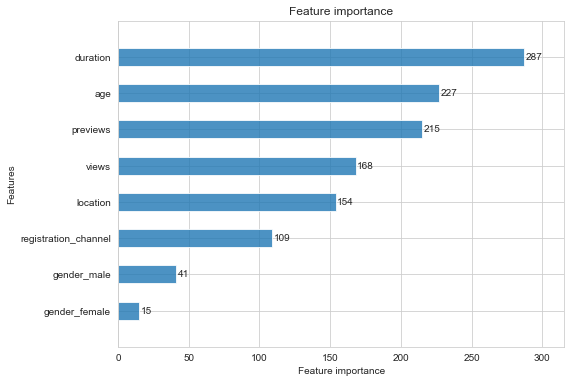

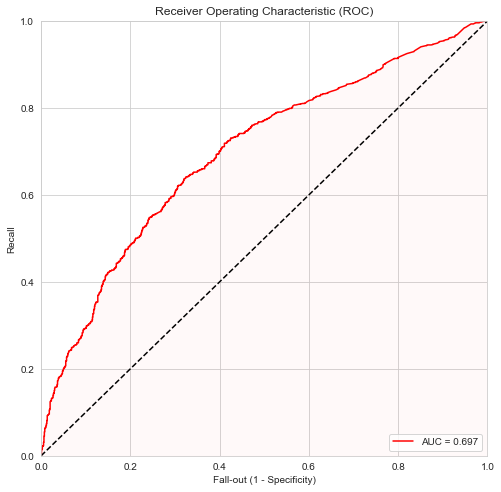

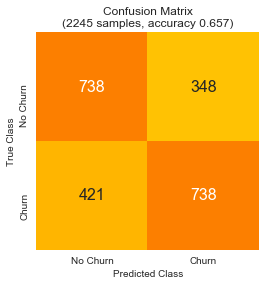

In [9]:
# 
# Plot accuracy measures and diagnostic information
#

# Predict on test set
predictions_lgbm_prob = lgbm.predict(x_test)

# Plot feature importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split',
                    height=0.5, color='#1f77b4', alpha=0.8, figsize=(8, 6))

# plot ROC
plot_roc(y_test, predictions_lgbm_prob)

# plot confusion matrix
plot_confusion_matrix(y_test, predictions_lgbm_prob, ['No Churn', 'Churn'])

LSTM Model

In [14]:
#
# Feature engineering for Keras
#
x, y = profiles[['location', 'age', 'registration_channel',  'gender_female', 'gender_male']], profiles['is_churn']
x = pd.get_dummies(x, columns=['registration_channel'])

def normalize(df, columns):
    for c in columns:
        df.loc[:, c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())

# normalization is important for neural nets
normalize(x, x.columns)

In [15]:
print_df(x)

+-------+------------+-----------+-----------------+---------------+--------------------------+--------------------------+--------------------------+--------------------------+---------------------------+
|   uid |   location |       age |   gender_female |   gender_male |   registration_channel_3 |   registration_channel_4 |   registration_channel_7 |   registration_channel_9 |   registration_channel_13 |
|-------+------------+-----------+-----------------+---------------+--------------------------+--------------------------+--------------------------+--------------------------+---------------------------|
|     0 |   0.666667 | 0.07034   |               1 |             0 |                        1 |                        0 |                        0 |                        0 |                         0 |
|     1 |   0.571429 | 0.0973036 |               1 |             0 |                        0 |                        0 |                        0 |                        1 |    

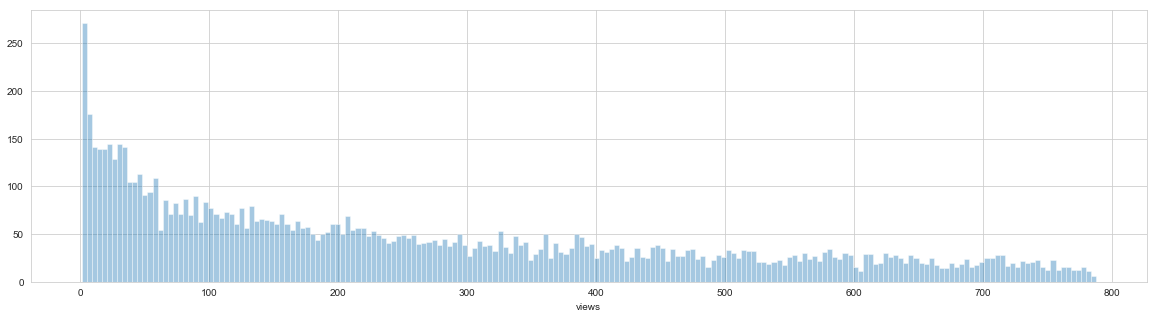

In [16]:
#
# plot how the number of activity records per user is distributed 
#
plt.figure(figsize=(20, 5));
sns.distplot(df_logs.groupby('uid').count()['views'], bins = 200, kde = False);



In [17]:
#
# aggregate daily activity records into buckets (e.g. weekly) and normalize
#
df_logs['time_bucket'] = -((df_logs['date'].max() - df_logs['date']).dt.days / 7).astype(int)
df_logs_weekly = df_logs.groupby(['uid', 'time_bucket']).sum()
normalize(df_logs_weekly, df_logs_weekly.columns)
print_df(df_logs_weekly)

+-----------+------------+------------+------------+
|           |      views |   duration |   previews |
|-----------+------------+------------+------------|
| (0, -104) | 0.0235781  |  0.157603  | 0.0537202  |
| (0, -103) | 0.0181785  |  0.118646  | 0.0522838  |
| (0, -102) | 0.0179986  |  0.121152  | 0.0531456  |
| (0, -101) | 0.00971922 |  0.0713638 | 0.054582   |
| (0, -100) | 0.0050396  |  0.0431612 | 0.0410801  |
| (0, -99)  | 0.00233981 |  0.0152113 | 0.0140764  |
| (0, -98)  | 0.0050396  |  0.0503199 | 0.0287274  |
| (0, -97)  | 0.0142189  |  0.0916665 | 0.027291   |
| (0, -96)  | 0.00143988 |  0.0119743 | 0.00861821 |
| (0, -95)  | 0.0109791  |  0.0620549 | 0.0221201  |
+-----------+------------+------------+------------+
507445 rows x 3 columns


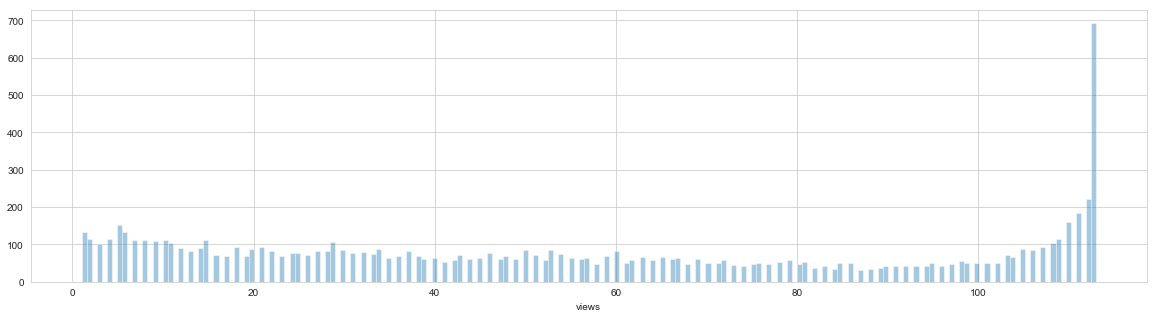

In [18]:
#
# plot how the number of weekly activity records per user is distributed 
#
plt.figure(figsize=(20, 5));
sns.distplot(df_logs_weekly.groupby('uid').count()['views'], bins = 200, kde = False);



In [19]:
#
# Feature engineering for Keras: 3D tensor for LSTM (n_users x events_per_user x n_features_per_event)
#
a3d = df_logs_weekly.sort_values(['uid', 'time_bucket']).groupby('uid').apply(pd.DataFrame.to_numpy)
n_users = len(df_users)
events_per_user = df_logs_weekly.groupby('uid').count()['views'].max()
n_features = len(df_logs_weekly.columns)
x3d = np.zeros((n_users, events_per_user, n_features))
for uid in df_users.index:
    if uid in df_logs.index:
        n_events = min(events_per_user, len(a3d[uid]))
        x3d[uid, -n_events:, :] = a3d[uid][-n_events:, :]
        
print(f'Input tensor shapes: x3d {x3d.shape}, x {x.shape}, y {y.shape}')

Input tensor shapes: x3d (8979, 113, 3), x (8979, 9), y (8979,)


In [20]:
#
# Train-test split
#
x3d_train, x3d_test, x_train, x_test, y_train, y_test = train_test_split(x3d, x, y, test_size = 0.25, random_state = 1)

In [21]:
#
# Model specification
#

# Inputs
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
lstm_out = LSTM(8, input_shape=(events_per_user, n_features))(input_logs)
lstm_tower = Model(inputs=input_logs, outputs=lstm_out)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top_1 = Dense(32, activation='relu')(combined)
dense_top_2 = Dense(16, activation='relu')(dense_top_1)
dense_top_3 = Dense(8, activation='relu')(dense_top_2)
prob_churn = Dense(1, activation='sigmoid')(dense_top_3)
model = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_churn)

#
# Model training
#
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/10
421/421 [==============================] - 17s 30ms/step - loss: 0.6593 - accuracy: 0.6214 - val_loss: 0.6225 - val_accuracy: 0.6654
Epoch 2/10
421/421 [==============================] - 12s 28ms/step - loss: 0.6211 - accuracy: 0.6668 - val_loss: 0.6170 - val_accuracy: 0.6720
Epoch 3/10
421/421 [==============================] - 11s 27ms/step - loss: 0.6086 - accuracy: 0.6748 - val_loss: 0.6164 - val_accuracy: 0.6705
Epoch 4/10
421/421 [==============================] - 12s 27ms/step - loss: 0.6169 - accuracy: 0.6687 - val_loss: 0.6177 - val_accuracy: 0.6645
Epoch 5/10
421/421 [==============================] - 12s 28ms/step - loss: 0.6051 - accuracy: 0.6789 - val_loss: 0.5974 - val_accuracy: 0.6876
Epoch 6/10
421/421 [==============================] - 12s 28ms/step - loss: 0.6024 - accuracy: 0.6822 - val_loss: 0.5863 - val_accuracy: 0.6994
Epoch 7/10
421/421 [==============================] - 12s 28ms/step - loss: 0.5963 - accuracy: 0.6873 - val_loss: 0.5703 - val_accuracy:

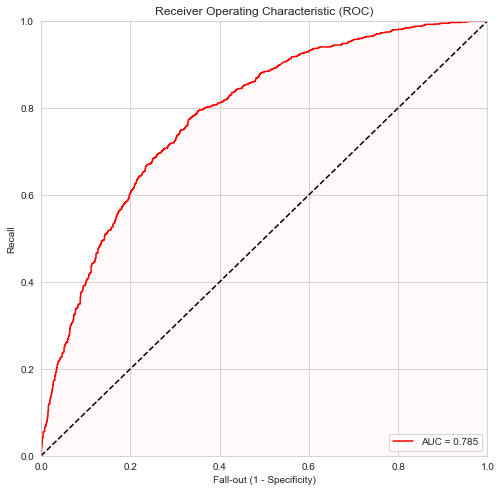

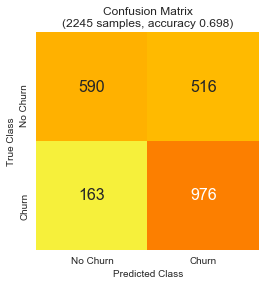

In [22]:
predictions_lstm_prob = model.predict([x3d_test, x_test])

# plot ROC
plot_roc(y_test, predictions_lstm_prob)

# plot confusion matrix
plot_confusion_matrix(y_test, predictions_lstm_prob, ['No Churn', 'Churn'])



LSTM with Attention

In [23]:
#
# Model parameters
#
hidden_units = 8

#
# Model specification
#
input_logs = Input(shape=(events_per_user, n_features))
input_user = Input(shape=(x.shape[1],))

# LSTM tower
activations = LSTM(hidden_units, return_sequences=True)(input_logs)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

lstm_tower = Model(inputs=input_logs, outputs=weighted_activations)

# User profile tower
profile_out = Dense(16, activation='relu')(input_user)
profile_tower = Model(inputs=input_user, outputs=profile_out)

# Model head
combined = Concatenate()([lstm_tower.output, profile_tower.output])
dense_top = Dense(32, activation='relu')(combined)
prob_churn = Dense(1, activation='sigmoid')(dense_top)
model = Model(inputs=[lstm_tower.input, profile_tower.input], outputs=prob_churn)

#
# Model training
#
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit([x3d_train, x_train], y_train, batch_size=16, epochs=10, verbose=1, validation_data=([x3d_train, x_train], y_train)) 
score = model.evaluate([x3d_test, x_test], y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Epoch 1/10
421/421 [==============================] - 14s 29ms/step - loss: 0.6536 - accuracy: 0.6378 - val_loss: 0.6196 - val_accuracy: 0.6712
Epoch 2/10
421/421 [==============================] - 12s 28ms/step - loss: 0.6149 - accuracy: 0.6821 - val_loss: 0.6143 - val_accuracy: 0.6736
Epoch 3/10
421/421 [==============================] - 12s 28ms/step - loss: 0.6167 - accuracy: 0.6742 - val_loss: 0.6121 - val_accuracy: 0.6761
Epoch 4/10
421/421 [==============================] - 12s 30ms/step - loss: 0.6189 - accuracy: 0.6761 - val_loss: 0.6113 - val_accuracy: 0.6767
Epoch 5/10
421/421 [==============================] - 13s 30ms/step - loss: 0.6117 - accuracy: 0.6790 - val_loss: 0.6101 - val_accuracy: 0.6766
Epoch 6/10
421/421 [==============================] - 12s 29ms/step - loss: 0.6060 - accuracy: 0.6824 - val_loss: 0.6094 - val_accuracy: 0.6795
Epoch 7/10
421/421 [==============================] - 13s 30ms/step - loss: 0.6078 - accuracy: 0.6832 - val_loss: 0.6114 - val_accuracy:

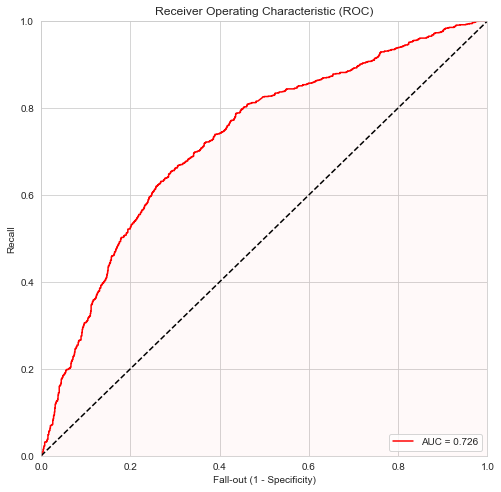

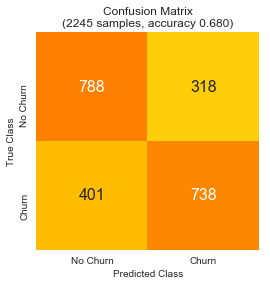

In [24]:
predictions_lstm_a_prob = model.predict([x3d_test, x_test])

# plot ROC
plot_roc(y_test, predictions_lstm_a_prob)

# plot confusion matrix
plot_confusion_matrix(y_test, predictions_lstm_a_prob, ['No Churn', 'Churn'])



In [25]:
#
# Attention weights analysis
#

attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weigths').output)
a = attention_model.predict([x3d_test, x_test])
print(f'Attention weights matrix: {a.shape[0]} users x {a.shape[1]} weights')

Attention weights matrix: 2245 users x 113 weights


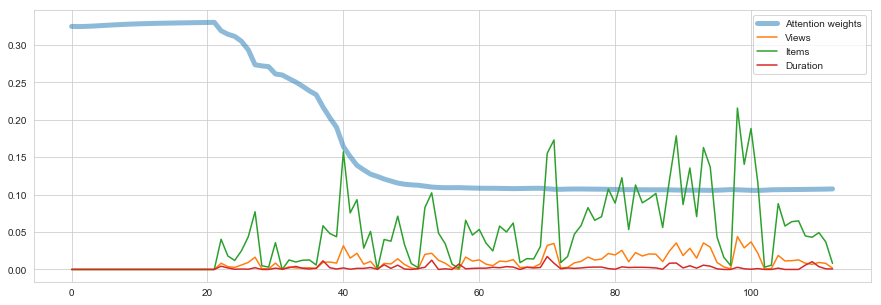

In [26]:
uid = 30
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(20 * a[uid, :], label='Attention weights', linewidth=5, alpha=0.5)
for i, column in zip(range(n_features), ['Views', 'Items', 'Duration', 'Previews']):
    ax.plot(x3d_test[uid][:, i], label=column)
ax.legend();